In [1]:
import sys
import os
# Add the 'project' directory to the path
sys.path.append(os.path.abspath('..'))

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import pickle
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from project_code.data.load_data import load_dataframes
from project_code.data.prepare_data_sklearn import get_features_targets
from project_code.evaluate.prediction_error import METRIC_LABEL_TO_NAME
from project_code.plotters.infeasibility import method_labels

# Settings

In [4]:
margin_factor = 0.05
loss_tolerance_for_minimum = 1e-4

In [5]:
def adjust_axes_to_square(ax):
    """
    Adjusts the provided axes to have square limits ensuring all data is visible,
    sets the aspect ratio to equal, and plots a y = x line.
    """
    # Retrieve current axis limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # Determine the overall limits to include all data
    lower = min(x_min, y_min)
    upper = max(x_max, y_max)
    
    # Update the axes limits to be the same for both x and y
    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    
    # Set the aspect ratio to equal for a square view
    #ax.set_aspect('equal', adjustable='box')
    
    # Plot the y = x line
    ax.plot([lower, upper], [lower, upper], 'k--', label='y = x')

# Loading data and results

In [6]:
results_folder = f'../results/'
fig_save_folder = f'../paper/figures/'
method_list = ['BijectionMethod', 'MLP', 'MLPSC', 'Taxo1NN', 'SRTaxo1NN']

## Load data

In [7]:
dataset_name = 'final'

dataset_name += '_taxonomy'
dataset_name += '_ecocodes'

# Load the data
dataset_folder = f'../data/processed/'
dfs, col_types = load_dataframes(dataset_name=dataset_name, data_split='train_test', datasets_folder=dataset_folder)
data = get_features_targets(dfs, col_types)

## Load initial DEB loss results

In [8]:
deb_loss_results_folder = os.path.join(results_folder, 'deb_model_loss')
deb_loss_df_dict = {}
for file in os.listdir(deb_loss_results_folder):
    model_name = file.split('_deb_model_loss.csv')[0]
    if 'AmP' in model_name:
        continue
    df = pd.read_csv(os.path.join(deb_loss_results_folder, file), index_col=0)
    df.index.name = 'species'
    df['success'] = df['success'].astype(bool)

    # Convert final_loss column to complex type if it is of type object
    if df['deb_loss'].dtype == np.dtype('O'):
        df['deb_loss'] = df['deb_loss'].apply(lambda x: complex(x.replace('i', 'j')) if isinstance(x, str) else x)

    # Set error if loss is imaginary
    imaginary_loss_mask = df['deb_loss'].apply(lambda x: x.imag != 0 if isinstance(x, complex) else False)
    df.loc[imaginary_loss_mask, 'success'] = False
    df.loc[imaginary_loss_mask, 'error_message'] = 'Final loss has imaginary part'
    df.loc[imaginary_loss_mask, 'deb_loss'] = np.nan
    df['deb_loss'] = df['deb_loss'].astype(float)

    # Set error message on not passing predict custom filters
    df.loc[df['error_type'] == 'predict_filter', 'error_message'] = 'Did not pass custom filters'
    # Set error message for timeout
    df.loc[df['error_type'] == 'timeout', 'error_message'] = 'Maximum time limit exceeded'
    # Set error message for NaN loss
    df.loc[df['deb_loss'].isna() & df['success'], 'error_message'] = 'Initial loss is NaN'
    df.loc[df['error_message'] == 'Initial loss is NaN', 'success'] = False


    deb_loss_df_dict[model_name] = df
print(*deb_loss_df_dict.keys(), sep='\n')

BijectionMethod
MLPSC
MLP
SRTaxo1NN
Taxo1NN


c:\Users\diogo\miniconda3\envs\ml_bijection\lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\diogo\miniconda3\envs\ml_bijection\lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\diogo\miniconda3\envs\ml_bijection\lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
c:\Users\diogo\miniconda3\envs\ml_bijection\lib\site-packages\pandas\core\dtypes\astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [9]:
deb_loss_df = pd.concat(deb_loss_df_dict).reset_index(level=0, names='method')
#init_df.loc[~init_df['error'].isna(), 'error_type'] = 'timeout'
#init_df['convergence'] = init_df['convergence'].astype(bool)
#init_df.drop(columns=['error'], inplace=True)
deb_loss_df

,method,data_split,deb_loss,success,error_type,error_message
species,,,,,,
Ablennes_hians,BijectionMethod,test,2.258935,True,NaN,NaN
Acanthogobius_flavimanus,BijectionMethod,test,8.369720,True,NaN,NaN
Acanthopagrus_arabicus,BijectionMethod,test,0.451156,True,NaN,NaN
Achoerodus_gouldii,BijectionMethod,test,1.265581,True,NaN,NaN
Achondrostoma_arcasii,BijectionMethod,test,10.125168,True,NaN,NaN
...,...,...,...,...,...,...
Anolis_gundlachi,Taxo1NN,test,2.183193,True,NaN,NaN
Neotrygon_kuhlii,Taxo1NN,test,2.730107,True,NaN,NaN
Cinnyris_osea,Taxo1NN,test,2.681778,True,NaN,NaN


## Load initialization results

In [10]:
init_results_folder = os.path.join(results_folder, 'initialization')
init_df_dict = {}
for file in os.listdir(init_results_folder):
    model_name = file.split('_initialization.csv')[0]
    df = pd.read_csv(os.path.join(init_results_folder, file), index_col=0)
    df.index.name = 'species'
    df['convergence'] = df['convergence'].astype(bool)
    df['error'] = df['error'].astype(bool)
    df.loc[df['error'], 'deb_loss'] = np.nan

    # Convert final_loss column to complex type if it is of type object
    if df['deb_loss'].dtype == np.dtype('O'):
        df['deb_loss'] = df['deb_loss'].apply(lambda x: complex(x.replace('i', 'j')) if isinstance(x, str) else x)

    # Set error if loss is imaginary
    imaginary_loss_mask = df['deb_loss'].apply(lambda x: x.imag != 0 if isinstance(x, complex) else False)
    df.loc[imaginary_loss_mask, 'error'] = True
    df.loc[imaginary_loss_mask, 'error_message'] = 'Final loss has imaginary part'
    df.loc[imaginary_loss_mask, 'deb_loss'] = np.nan
    df['deb_loss'] = df['deb_loss'].astype(float)

    # Set error message for NaN loss
    df.loc[df['deb_loss'].isna() & ~df['error'], 'error_message'] = 'Final loss is NaN'
    df.loc[df['error_message'] == 'Final loss is NaN', 'error'] = True

    # Drop species that did not succeed in computing initial loss
    df = df[deb_loss_df_dict[model_name]['success']]


    init_df_dict[model_name] = df
print(*init_df_dict.keys(), sep='\n')

BijectionMethod
MLPSC
MLP
SRTaxo1NN
Taxo1NN


C:\Users\diogo\AppData\Local\Temp\ipykernel_38532\4268335155.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[deb_loss_df_dict[model_name]['success']]
C:\Users\diogo\AppData\Local\Temp\ipykernel_38532\4268335155.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[deb_loss_df_dict[model_name]['success']]
C:\Users\diogo\AppData\Local\Temp\ipykernel_38532\4268335155.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[deb_loss_df_dict[model_name]['success']]
C:\Users\diogo\AppData\Local\Temp\ipykernel_38532\4268335155.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[deb_loss_df_dict[model_name]['success']]
C:\Users\diogo\AppData\Local\Temp\ipykernel_38532\4268335155.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[deb_loss_df_dict[model_name]['success']]


In [11]:
deb_loss_df_dict['MLP'].loc[~deb_loss_df_dict['MLP']['success']]

,data_split,deb_loss,success,error_type,error_message
species,,,,,
Photopectoralis_bindus,test,NaN,False,NaN,Final loss has imaginary part
Acipenser_transmontanus,test,NaN,False,predict_filter,Did not pass custom filters
Hydromedusa_maximiliani,test,NaN,False,NaN,Initial loss is NaN
Gallus_gallus_IR,test,NaN,False,predict_filter,Did not pass custom filters
Oncorhynchus_tshawytscha,test,NaN,False,predict_or_loss_error,The entries in tspan must strictly increase or...
Lissodelphis_borealis,test,NaN,False,NaN,Initial loss is NaN
Oryctolagus_cuniculus_NZW,test,NaN,False,predict_filter,Did not pass custom filters
Crystallogobius_linearis,test,NaN,False,predict_filter,Did not pass custom filters
Orectolobus_ornatus,test,NaN,False,predict_filter,Did not pass custom filters


In [12]:
init_df_dict['MLP'].loc[~deb_loss_df_dict['MLP']['success']]

,data_split,deb_loss,convergence,n_runs,n_iter,execution_time,error,error_message
species,,,,,,,,


In [13]:
init_df = pd.concat(init_df_dict).reset_index(level=0, names='method')
#init_df.loc[~init_df['error'].isna(), 'error_type'] = 'timeout'
init_df['convergence'] = init_df['convergence'].astype(bool)
init_df.drop(columns=['error'], inplace=True)
init_df

,method,data_split,deb_loss,convergence,n_runs,n_iter,execution_time,error_message
species,,,,,,,,
Ablennes_hians,BijectionMethod,test,0.022363,False,14,7000,347.134306,NaN
Acanthogobius_flavimanus,BijectionMethod,test,0.203531,False,10,5000,136.484581,NaN
Acanthopagrus_arabicus,BijectionMethod,test,0.047610,False,4,2000,77.931348,NaN
Achoerodus_gouldii,BijectionMethod,test,NaN,False,0,0,4320.000000,Maximum execution time exceeded
Achondrostoma_arcasii,BijectionMethod,test,0.021085,False,9,4500,194.789593,NaN
...,...,...,...,...,...,...,...,...
Anolis_gundlachi,Taxo1NN,test,0.076927,False,4,2000,85.980609,NaN
Neotrygon_kuhlii,Taxo1NN,test,0.111619,False,6,3000,259.352981,NaN
Cinnyris_osea,Taxo1NN,test,0.104003,False,11,5500,456.730214,NaN


In [14]:
init_df.groupby(by=['method', 'convergence']).count()

data_split  deb_loss  n_runs  n_iter  \
method          convergence                                         
BijectionMethod False               128       101     128     128   
                True                 11        11      11      11   
MLP             False               324       292     324     324   
                True                 15        15      15      15   
MLPSC           False               320       295     320     320   
                True                 21        21      21      21   
SRTaxo1NN       False               306       262     306     306   
                True                 21        21      21      21   
Taxo1NN         False               313       257     313     313   
                True                 15        15      15      15   

                             execution_time  error_message  
method          convergence                                 
BijectionMethod False                   128             27  
                True                     11              0  
MLP             False                   324             32  
                True                     15              0  
MLPSC           False                   320             25  
                True                     21              0  
SRTaxo1NN       False                   306             44  
                True                     21              0  
Taxo1NN         False                   313             56  
                True                     15              0

## Load ground truth

In [15]:
gt_model_name = 'AmP_minimum'
#gt_model_name = 'AmP'

gt_df = pd.read_csv(os.path.join(deb_loss_results_folder, f'{gt_model_name}_deb_model_loss.csv'), index_col=0)
gt_df.dropna(subset=['deb_loss', 'success'], how='any')
gt_df = gt_df[gt_df['success'].astype(bool)]
gt_df = gt_df[gt_df['data_split'] == 'test']
#gt_df = gt_df[gt_df.index.isin(init_df_dict['MLP'].index)]
gt_df

,data_split,deb_loss,weight_sum,success,error_type,error_message
Row,,,,,,
Ablennes_hians,test,0.008185,37.5,1,NaN,NaN
Acanthiza_chrysorrhoa,test,0.102778,31.4,1,NaN,NaN
Acanthogobius_flavimanus,test,0.203531,37.5,1,NaN,NaN
Acanthopagrus_arabicus,test,0.045766,31.5,1,NaN,NaN
Accipiter_fasciatus,test,0.080450,34.4,1,NaN,NaN
...,...,...,...,...,...,...
Varanus_bengalensis,test,0.217409,32.6,1,NaN,NaN
Vermivora_cyanoptera,test,0.102015,32.4,1,NaN,NaN
Wallabia_bicolor,test,0.151367,32.6,1,NaN,NaN


# Compare models

In [16]:
loss_diff_df_dict = {}

for method in init_df_dict.keys():
    if method == 'AmP': 
        continue
    else:
        df = init_df.groupby('method').get_group(method)
        loss_diff_df_dict[method] = pd.DataFrame(index=gt_df.index, columns=['data_split', 'init_loss', 'deb_loss', 'loss_improv', 'norm_loss_improv', 'loss_diff', 'loss_gap', 'norm_loss_diff'])
        loss_diff_df_dict[method]['data_split'] = gt_df['data_split']
        for species in gt_df.index.values:
            if species not in df.index:
                loss_diff_df_dict[method].at[species, 'init_loss'] = np.nan
                loss_diff_df_dict[method].at[species, 'deb_loss'] = np.nan
                loss_diff_df_dict[method].at[species, 'loss_diff'] = np.nan
                loss_diff_df_dict[method].at[species, 'loss_gap'] = np.nan
            else:
                loss_diff_df_dict[method].at[species, 'init_loss'] = deb_loss_df_dict[method].at[species, 'deb_loss']
                loss_diff_df_dict[method].at[species, 'init_loss_diff'] = deb_loss_df_dict[method].at[species, 'deb_loss'] - gt_df.at[species, 'deb_loss']
                loss_diff_df_dict[method].at[species, 'deb_loss'] = df.at[species, 'deb_loss']
                loss_diff_df_dict[method].at[species, 'loss_improv'] = deb_loss_df_dict[method].at[species, 'deb_loss'] - df.at[species, 'deb_loss']
                loss_diff_df_dict[method].at[species, 'loss_diff'] = df.at[species, 'deb_loss'] - gt_df.at[species, 'deb_loss']
                loss_diff_df_dict[method].at[species, 'loss_gap'] = (df.at[species, 'deb_loss'] / gt_df.at[species, 'deb_loss'] - 1) 
            loss_diff_df_dict[method]['norm_init_loss_diff'] = loss_diff_df_dict[method]['init_loss_diff'] / gt_df['weight_sum']
            loss_diff_df_dict[method]['norm_loss_improv'] = loss_diff_df_dict[method]['loss_improv'] / gt_df['weight_sum']
            loss_diff_df_dict[method]['norm_loss_diff'] = loss_diff_df_dict[method]['loss_diff'] / gt_df['weight_sum']

loss_diff_df = pd.concat(loss_diff_df_dict).reset_index(level=0, names='method')
loss_diff_df

,method,data_split,init_loss,deb_loss,loss_improv,norm_loss_improv,loss_diff,loss_gap,norm_loss_diff,init_loss_diff,norm_init_loss_diff
Row,,,,,,,,,,,
Ablennes_hians,BijectionMethod,test,2.258935,0.022363,2.236572,0.059642,0.014178,1.732109,0.000378,2.250750,0.060020
Acanthiza_chrysorrhoa,BijectionMethod,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Acanthogobius_flavimanus,BijectionMethod,test,8.36972,0.203531,8.166189,0.217765,0.000001,0.000003,0.0,8.166190,0.217765
Acanthopagrus_arabicus,BijectionMethod,test,0.451156,0.04761,0.403546,0.012811,0.001844,0.040286,0.000059,0.405389,0.012870
Accipiter_fasciatus,BijectionMethod,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Varanus_bengalensis,Taxo1NN,test,5.608041,0.217409,5.390631,0.165357,0.0,0.0,0.0,5.390631,0.165357
Vermivora_cyanoptera,Taxo1NN,test,1.475753,0.102729,1.373024,0.042377,0.000714,0.006995,0.000022,1.373738,0.042399
Wallabia_bicolor,Taxo1NN,test,9.70961,0.429844,9.279765,0.284655,0.278478,1.839752,0.008542,9.558243,0.293198


## Compare on anything

In [17]:
loss_diff_df.sort_values(by='norm_loss_improv', ascending=False)

,method,data_split,init_loss,deb_loss,loss_improv,norm_loss_improv,loss_diff,loss_gap,norm_loss_diff,init_loss_diff,norm_init_loss_diff
Row,,,,,,,,,,,
Ablennes_hians,Taxo1NN,test,277.705482,0.034648,277.670834,7.404556,0.026463,3.232983,0.000706,277.697297,7.405261
Cyphomyrus_discorhynchus,Taxo1NN,test,37.340761,0.033585,37.307176,1.113647,-0.007118,-0.174868,-0.000212,37.300058,1.113435
Eisenia_fetida,Taxo1NN,test,83.381186,2.298421,81.082765,0.996103,-0.002207,-0.000959,-0.000027,81.080558,0.996076
Notothenia_neglecta,SRTaxo1NN,test,28.495293,1.235411,27.259882,0.838766,1.162263,15.889231,0.035762,28.422145,0.874528
Torpedo_marmorata,SRTaxo1NN,test,94.48462,1.277727,93.206893,0.719744,1.112507,6.733479,0.008591,94.319400,0.728335
...,...,...,...,...,...,...,...,...,...,...,...
Trichomycterus_itacarambiensis,Taxo1NN,test,1.752321,NaN,NaN,NaN,NaN,NaN,NaN,1.675108,0.054922
Triturus_cristatus,Taxo1NN,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Troglodytes_aedon,Taxo1NN,test,5.353982,NaN,NaN,NaN,NaN,NaN,NaN,5.213481,0.147273


### Boxplots

In [18]:
def boxplot_compare_methods(xvar):
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    sns.stripplot(ax=ax, data=loss_diff_df.reset_index(), x=xvar, y='method', hue='method')
    sns.boxplot(ax=ax, data=loss_diff_df.reset_index(), x=xvar, y='method', color='black', fill=False, whis=1000000)
    ax.set_xlabel('Normalized difference to the loss computed with the parameters in the AmP database')
    ax.set_ylabel('')

xvar_selector = widgets.Dropdown(options=loss_diff_df.columns, value='norm_loss_diff', description='Variable: ')
widgets.interactive(boxplot_compare_methods, xvar=xvar_selector)

interactive(children=(Dropdown(description='Variable: ', index=8, options=('method', 'data_split', 'init_loss'…

### Scatterplots

In [19]:
def scatterplot_compare_methods(var, method1, method2, scale):
    pivot_df = loss_diff_df.pivot(columns='method', values=var)
    ax = sns.scatterplot(data=pivot_df, x=method1, y=method2)
    adjust_axes_to_square(ax)

    ax.grid(True)
    ax.set_title(var)
    if scale == 'linear':
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    else:
        ax.set_xscale('log')
        ax.set_yscale('log')


var_selector = widgets.Dropdown(options=loss_diff_df.columns, value='norm_loss_diff', description='Variable: ')
method1_selector = widgets.Dropdown(options=init_df_dict.keys(), value='BijectionMethod', description='Method 1:')
method2_selector = widgets.Dropdown(options=init_df_dict.keys(), value='MLP', description='Method 2:')
scale_selector = widgets.Dropdown(options=['linear', 'log'], value='linear', description='Scale:')

widgets.interactive(scatterplot_compare_methods, var=var_selector, method1=method1_selector, method2=method2_selector, scale=scale_selector)

interactive(children=(Dropdown(description='Variable: ', index=8, options=('method', 'data_split', 'init_loss'…

In [20]:
loss_diff_compare_df = loss_diff_df.pivot(columns='method', values='norm_loss_diff')
loss_diff_compare_df

method,BijectionMethod,MLP,MLPSC,SRTaxo1NN,Taxo1NN
Row,,,,,
Ablennes_hians,0.000378,0.000045,-0.000073,0.000087,0.000706
Acanthiza_chrysorrhoa,NaN,-0.000012,0.000024,0.000025,-0.000027
Acanthogobius_flavimanus,0.0,0.000002,0.000002,0.000001,0.0
Acanthopagrus_arabicus,0.000059,-0.00002,0.0,0.000052,-0.000004
Accipiter_fasciatus,NaN,0.000001,NaN,NaN,NaN
...,...,...,...,...,...
Varanus_bengalensis,NaN,0.0,0.0,0.0,0.0
Vermivora_cyanoptera,NaN,-0.000009,0.00002,-0.000029,0.000022
Wallabia_bicolor,NaN,0.0,0.0,0.0,0.008542


In [21]:
(loss_diff_compare_df['SRTaxo1NN'] > loss_diff_compare_df['MLP']).sum()

np.int64(142)

## Stats

### Errors, Nº Minimum achieved, Nº improved

In [101]:
deb_loss_df_dict['SRTaxo1NN']['success'].value_counts()

success
True     327
False     26
Name: count, dtype: int64

In [85]:
init_df_dict['MLPSC']['error'].value_counts()

error
False    316
True      25
Name: count, dtype: int64

In [96]:
deb_loss_df_dict['MLPSC'].loc[loss_diff_df_dict['MLPSC']['deb_loss'].isna()]

,data_split,deb_loss,success,error_type,error_message
species,,,,,
Photopectoralis_bindus,test,NaN,False,NaN,Final loss has imaginary part
Pyxicephalus_adspersus,test,13.146599,True,NaN,NaN
Acipenser_transmontanus,test,NaN,False,predict_filter,Did not pass custom filters
Oxyura_jamaicensis,test,2.116576,True,NaN,NaN
Pleurodeles_waltl,test,5.609759,True,NaN,NaN
Bombina_variegata,test,1.869572,True,NaN,NaN
Accipiter_fasciatus,test,5.389938,True,NaN,NaN
Eutrigla_gurnardus,test,0.818971,True,NaN,NaN
Pelophylax_bedriagae,test,2.988803,True,NaN,NaN


In [97]:
init_df_dict['MLPSC'].loc[loss_diff_df_dict['MLPSC']['deb_loss'].isna()]

,data_split,deb_loss,convergence,n_runs,n_iter,execution_time,error,error_message
species,,,,,,,,
Pyxicephalus_adspersus,test,NaN,False,0,0,1.014529,True,Incorrect dimensions for matrix multiplication...
Oxyura_jamaicensis,test,NaN,False,0,0,36.291762,True,Arrays have incompatible sizes for this operat...
Pleurodeles_waltl,test,NaN,False,0,0,0.664324,True,The logical indices contain a true value outsi...
Bombina_variegata,test,NaN,False,0,0,0.443432,True,Incorrect dimensions for matrix multiplication...
Accipiter_fasciatus,test,NaN,False,0,0,19.124301,True,The logical indices contain a true value outsi...
Eutrigla_gurnardus,test,NaN,False,0,0,4320.000000,True,Maximum execution time exceeded
Pelophylax_bedriagae,test,NaN,False,0,0,0.330529,True,Incorrect dimensions for matrix multiplication...
Schilbe_uranoscopus,test,NaN,False,0,0,4320.000000,True,Maximum execution time exceeded
Macruronus_novaezelandiae,test,NaN,False,0,0,0.659758,True,The logical indices contain a true value outsi...


In [114]:
stats_df = pd.DataFrame(index=method_list, 
                        columns=['n_minimum', 'n_improved', 'n_worsened', 
                                 'n_errors', 'n_timeouts', 'n_fail_custom_filters'],)
for method in method_list:
    #method = 'BijectionMethod'
    ld_df = loss_diff_df_dict[method]
    i_df = init_df_dict[method]
    dl_df = deb_loss_df_dict[method]
    stats_df.at[method, 'n_minimum'] = ( (ld_df['loss_diff'].abs() < loss_tolerance_for_minimum) & (~ld_df['deb_loss'].isna()) ).sum()
    stats_df.at[method, 'n_improved'] = ( (ld_df['loss_diff'] < -loss_tolerance_for_minimum) & (~ld_df['deb_loss'].isna()) ).sum()
    stats_df.at[method, 'n_worsened'] = ( (ld_df['loss_diff'] > loss_tolerance_for_minimum) & (~ld_df['deb_loss'].isna() )).sum()
    stats_df.at[method, 'n_timeouts'] = i_df[i_df['error_message'] == 'Maximum execution time exceeded'].shape[0]
    deb_loss_errors = dl_df[(dl_df['error_message'] != 'Did not pass custom filters') & (~dl_df['success'])].shape[0]
    run_errors = i_df[(i_df['error_message'] != 'Maximum execution time exceeded') & (i_df['error'])].shape[0]
    stats_df.at[method, 'n_errors'] = run_errors + deb_loss_errors
    stats_df.at[method, 'n_fail_custom_filters'] = dl_df[dl_df['error_message'] == 'Did not pass custom filters'].shape[0]
    #stats_df.at[method, 'n_nan'] = ld_df['deb_loss'].isna().sum()
    #stats_df.at[method, 'n_failures'] = ld_df['deb_loss'].isna().sum()

stats_df['n_infeasible'] = [11, 0, 1, 0, 0]
stats_df['n_failed'] = [200, 0, 0, 0, 0]
stats_df['n_success'] = stats_df[['n_minimum', 'n_improved', 'n_worsened']].sum(axis=1)
stats_df

,n_minimum,n_improved,n_worsened,n_errors,n_timeouts,n_fail_custom_filters,n_infeasible,n_failed,n_success
BijectionMethod,47,19,46,10,19,1,11,200,112
MLP,99,105,103,20,19,7,0,0,307
MLPSC,106,99,111,18,14,4,1,0,316
Taxo1NN,79,95,98,49,24,8,0,0,272
SRTaxo1NN,90,90,103,41,19,10,0,0,283


### Average values

In [26]:
mean_performance_df = pd.DataFrame(index=init_df_dict.keys(), 
                                   columns=[
                                       'mean_norm_init_loss_diff', 'std_norm_init_loss_diff',
                                       'mean_norm_loss_diff', 'std_norm_loss_diff',
                                       'mean_norm_loss_improv', 'std_norm_loss_improv',
                                       'mean_execution_time', 'std_execution_time', 
                                       'mean_n_iter', 'std_n_iter'
                                       ])
for method in init_df_dict.keys():
    df = loss_diff_df.groupby('method').get_group(method)
    mean_performance_df.at[method, 'mean_norm_init_loss_diff'] = df['norm_init_loss_diff'].mean()
    mean_performance_df.at[method, 'std_norm_init_loss_diff'] = df['norm_init_loss_diff'].std()
    mean_performance_df.at[method, 'mean_norm_loss_diff'] = df['norm_loss_diff'].mean()
    mean_performance_df.at[method, 'std_norm_loss_diff'] = df['norm_loss_diff'].std()
    mean_performance_df.at[method, 'mean_norm_loss_improv'] = df['norm_loss_improv'].mean()
    mean_performance_df.at[method, 'std_norm_loss_improv'] = df['norm_loss_improv'].std()
    mean_performance_df.at[method, 'mean_execution_time'] = init_df_dict[method]['execution_time'].mean()
    mean_performance_df.at[method, 'std_execution_time'] = init_df_dict[method]['execution_time'].std()
    mean_performance_df.at[method, 'mean_n_iter'] = init_df_dict[method]['n_iter'].mean()
    mean_performance_df.at[method, 'std_n_iter'] = init_df_dict[method]['n_iter'].std()
mean_performance_df.sort_values(by='mean_norm_loss_diff', ascending=True)

,mean_norm_init_loss_diff,std_norm_init_loss_diff,mean_norm_loss_diff,std_norm_loss_diff,mean_norm_loss_improv,std_norm_loss_improv,mean_execution_time,std_execution_time,mean_n_iter,std_n_iter
MLP,0.061472,0.07823,0.000773,0.008267,0.056238,0.061838,832.435512,1091.155279,5163.589971,4735.441714
MLPSC,0.055081,0.050736,0.00085,0.008744,0.051248,0.042066,463.999538,883.877134,5347.322581,4969.389201
BijectionMethod,0.070763,0.167377,0.002754,0.023017,0.054672,0.069573,858.839787,1508.419424,3948.345324,4961.050538
Taxo1NN,0.133068,0.420955,0.002829,0.024809,0.130209,0.457595,858.676805,1190.382727,4535.579268,4373.307175
SRTaxo1NN,0.089106,0.092274,0.003141,0.023617,0.082891,0.088856,920.951574,1152.121745,5819.275229,6116.411929


### Head-to-head

In [27]:
loss_diff_compare_df.sort_values(by='MLPSC', ascending=True)

method,BijectionMethod,MLP,MLPSC,SRTaxo1NN,Taxo1NN
Row,,,,,
Epinephelus_cyanopodus,-0.002989,-0.00411,-0.004111,0.006227,0.005891
Aerodramus_hirundinaceus,NaN,-0.002489,-0.002588,NaN,NaN
Urechis_caupo,NaN,-0.001946,-0.001946,-0.001946,-0.001946
Pterodroma_phaeopygia,NaN,-0.000397,-0.001903,NaN,-0.000145
Sarcoramphus_papa,NaN,-0.001639,-0.001639,0.000085,0.000121
...,...,...,...,...,...
Solea_senegalensis,NaN,NaN,NaN,NaN,0.000257
Sternula_antillarum,NaN,NaN,NaN,-0.000073,-0.000079
Takydromus_hsuehshanensis,NaN,NaN,NaN,NaN,NaN


In [146]:
from itertools import combinations

methods = init_df_dict.keys()
head2head_df = pd.DataFrame(index=methods, columns=init_df_dict.keys())
loss_pivot_df = loss_diff_df.pivot(columns='method', values='deb_loss') 
for method1, method2 in combinations(methods, 2):                
        wins1, ties, wins2 = 0, 0, 0
        
        for loss1, loss2 in zip(loss_pivot_df[method1], loss_pivot_df[method2]):
            if np.isnan(loss1) and np.isnan(loss2):
                ties += 1  # Both failed
            elif np.isnan(loss1):
                wins2 += 1  # Method1 failed, Method2 wins
            elif np.isnan(loss2):
                wins1 += 1  # Method2 failed, Method1 wins
            else:
                diff = abs(loss1 - loss2)
                if diff < loss_tolerance_for_minimum:
                    ties += 1
                elif loss1 < loss2 - loss_tolerance_for_minimum:
                    wins1 += 1
                elif loss2 < loss1 - loss_tolerance_for_minimum:
                    wins2 += 1
                else:
                    ties += 1
        #print(method1, method2, f"{wins1}-{ties}-{wins2}")
        head2head_df.at[method1, method2] = f"{wins1}-{ties}-{wins2}"
        head2head_df.at[method2, method1] = f"{wins2}-{ties}-{wins1}"
head2head_df

,BijectionMethod,MLPSC,MLP,SRTaxo1NN,Taxo1NN
BijectionMethod,NaN,23-84-246,30-84-239,42-94-217,42-102-209
MLPSC,246-84-23,NaN,103-144-106,148-108-97,145-104-104
MLP,239-84-30,106-144-103,NaN,142-117-94,146-104-103
SRTaxo1NN,217-94-42,97-108-148,94-117-142,NaN,102-135-116
Taxo1NN,209-102-42,104-104-145,103-104-146,116-135-102,NaN


### Head-to-head only for both successes

In [149]:
from itertools import combinations

head2head_success_df = pd.DataFrame(index=method_list, columns=method_list)
head2head_success_win_rate_df = pd.DataFrame(index=method_list, columns=method_list, dtype=float)
loss_pivot_df = loss_diff_df.pivot(columns='method', values='deb_loss') 
for method1, method2 in combinations(method_list, 2):                
        wins1, ties, wins2 = 0, 0, 0
        
        for loss1, loss2 in zip(loss_pivot_df[method1], loss_pivot_df[method2]):
            if np.isnan(loss1) or np.isnan(loss2):
                # If any of the methods failed, just continue
                continue
            else:
                diff = abs(loss1 - loss2)
                if diff < loss_tolerance_for_minimum:
                    ties += 1
                elif loss1 < loss2 - loss_tolerance_for_minimum:
                    wins1 += 1
                elif loss2 < loss1 - loss_tolerance_for_minimum:
                    wins2 += 1
                else:
                    ties += 1
        #print(method1, method2, f"{wins1}-{ties}-{wins2}")
        head2head_success_df.at[method1, method2] = f"{wins1}-{ties}-{wins2}"
        head2head_success_df.at[method2, method1] = f"{wins2}-{ties}-{wins1}"
        head2head_success_win_rate_df.at[method1, method2] = (wins1 + 0.5*ties) / (wins1 + wins2 + ties)
        head2head_success_win_rate_df.at[method2, method1] = (wins2 + 0.5*ties) / (wins1 + wins2 + ties)
head2head_success_df

,BijectionMethod,MLP,MLPSC,Taxo1NN,SRTaxo1NN
BijectionMethod,NaN,24-44-38,20-50-39,22-41-29,27-39-31
MLP,38-44-24,NaN,99-114-87,86-83-78,102-87-78
MLPSC,39-50-20,87-114-99,NaN,83-85-86,103-83-85
Taxo1NN,29-41-22,78-83-86,86-85-83,NaN,89-92-64
SRTaxo1NN,31-39-27,78-87-102,85-83-103,64-92-89,NaN


In [150]:
head2head_success_win_rate_df

,BijectionMethod,MLP,MLPSC,Taxo1NN,SRTaxo1NN
BijectionMethod,NaN,0.433962,0.412844,0.461957,0.479381
MLP,0.566038,NaN,0.520000,0.516194,0.544944
MLPSC,0.587156,0.480000,NaN,0.494094,0.533210
Taxo1NN,0.538043,0.483806,0.505906,NaN,0.551020
SRTaxo1NN,0.520619,0.455056,0.466790,0.448980,NaN


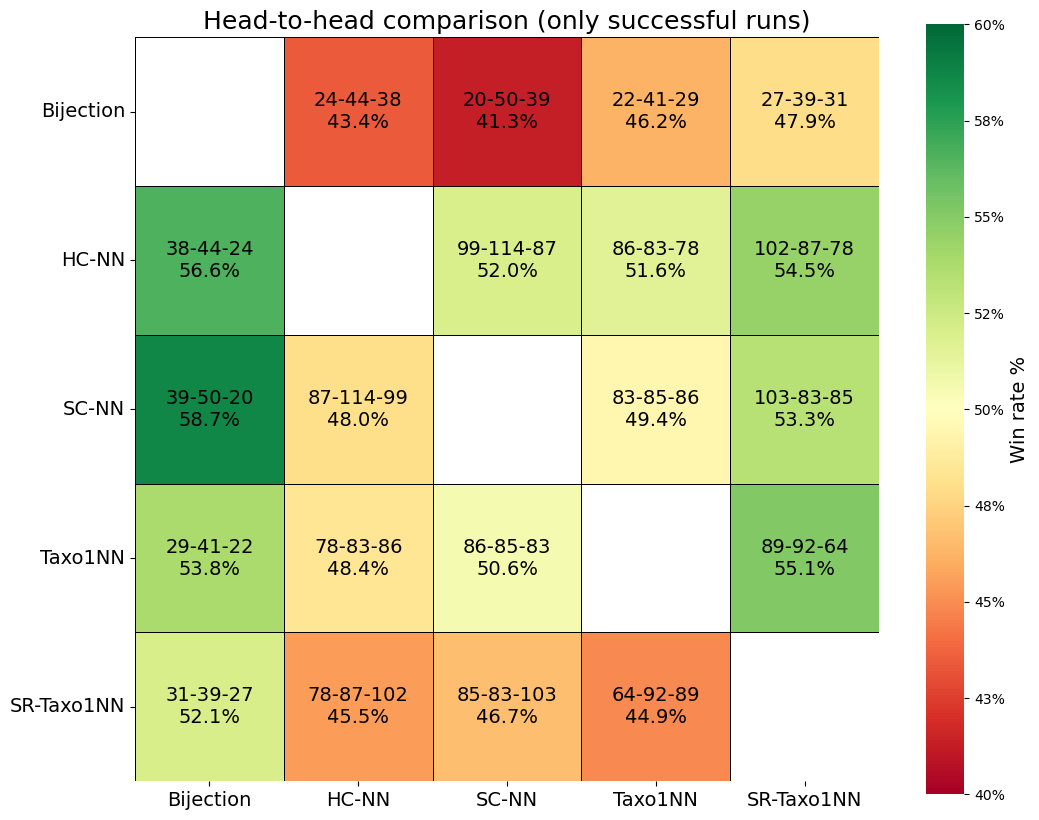

In [160]:
fig, ax = plt.subplots(figsize=(12, 10))
# Create a custom red-white-green colormap
red_white_green = LinearSegmentedColormap.from_list('red_white_green', ['red', 'white', 'green'])

sns.heatmap(head2head_success_win_rate_df, annot=False, ax=ax, 
            square=True, cmap='RdYlGn', cbar=True, 
            vmin=0.4, vmax=0.6, 
            linewidths=0.5, linecolor='black',)
# Set the title
ax.set_title('Head-to-head comparison (only successful runs)', fontsize=18)
# Map the axis labels to the method labels
ax.set_xticklabels([method_labels[method] for method in head2head_success_win_rate_df.columns], rotation=0, fontsize=14)
ax.set_yticklabels([method_labels[method] for method in head2head_success_win_rate_df.index], rotation=0, fontsize=14)
# Set the colorbar to percentage format
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
cbar.ax.set_ylabel('Win rate %', fontsize=14)
# Add the head-to-head and win rate annotations
for i in range(len(head2head_success_win_rate_df)):
    for j in range(len(head2head_success_win_rate_df)):
        if i != j:
            annot = f"{head2head_success_df.iloc[i, j]}\n{head2head_success_win_rate_df.iloc[i, j]:.1%}"
            ax.text(j + 0.5, i + 0.5, annot, 
                    ha='center', va='center', color='black', fontsize=14)

# Save the figure
fig_name = 'heatmap_head_to_head_success_only'
fig.savefig(f"{fig_save_folder}/{fig_name}.png", dpi=300, bbox_inches='tight')
fig.savefig(f"{fig_save_folder}/{fig_name}.pdf", dpi=300, bbox_inches='tight')

## Difference in loss function 

### Box plot

In [31]:
loss_diff_compare_df.sort_values(by='MLPSC', ascending=True)

method,BijectionMethod,MLP,MLPSC,SRTaxo1NN,Taxo1NN
Row,,,,,
Epinephelus_cyanopodus,-0.002989,-0.00411,-0.004111,0.006227,0.005891
Aerodramus_hirundinaceus,NaN,-0.002489,-0.002588,NaN,NaN
Urechis_caupo,NaN,-0.001946,-0.001946,-0.001946,-0.001946
Pterodroma_phaeopygia,NaN,-0.000397,-0.001903,NaN,-0.000145
Sarcoramphus_papa,NaN,-0.001639,-0.001639,0.000085,0.000121
...,...,...,...,...,...
Solea_senegalensis,NaN,NaN,NaN,NaN,0.000257
Sternula_antillarum,NaN,NaN,NaN,-0.000073,-0.000079
Takydromus_hsuehshanensis,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, '')

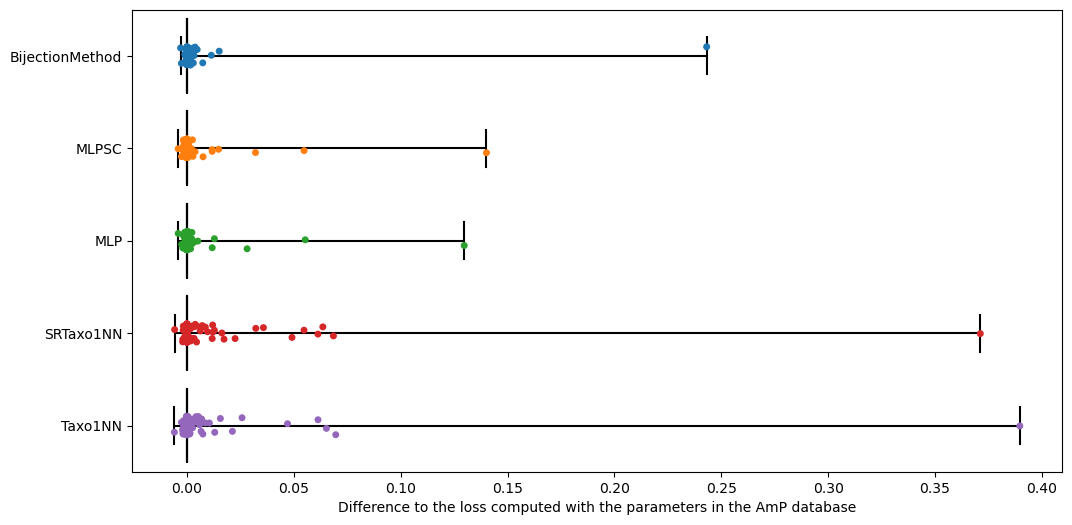

In [32]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
#ax.set_xscale('symlog')
xvar = 'norm_loss_diff'
#xvar = 'loss_diff'
sns.stripplot(ax=ax, data=loss_diff_df.reset_index(), x=xvar, y='method', hue='method')
sns.boxplot(ax=ax, data=loss_diff_df.reset_index(), x=xvar, y='method', color='black', fill=False, whis=1000000)
ax.set_xlabel('Difference to the loss computed with the parameters in the AmP database')
ax.set_ylabel('')


### Scatterplots

In [33]:
def scatterplot_loss_diff(method1, method2):
    ax = sns.scatterplot(data=loss_diff_compare_df, x=method1, y=method2)
    adjust_axes_to_square(ax)
    ax.grid(True)
    ax.set_title('Difference to the loss computed with the parameters in the AmP database')

method1_selector = widgets.Dropdown(options=loss_diff_compare_df.columns, value='BijectionMethod', description='Method 1:')
method2_selector = widgets.Dropdown(options=loss_diff_compare_df.columns, value='MLP', description='Method 2:')
widgets.interactive(scatterplot_loss_diff, method1=method1_selector, method2=method2_selector)


interactive(children=(Dropdown(description='Method 1:', options=('BijectionMethod', 'MLP', 'MLPSC', 'SRTaxo1NN…

### Pairplot

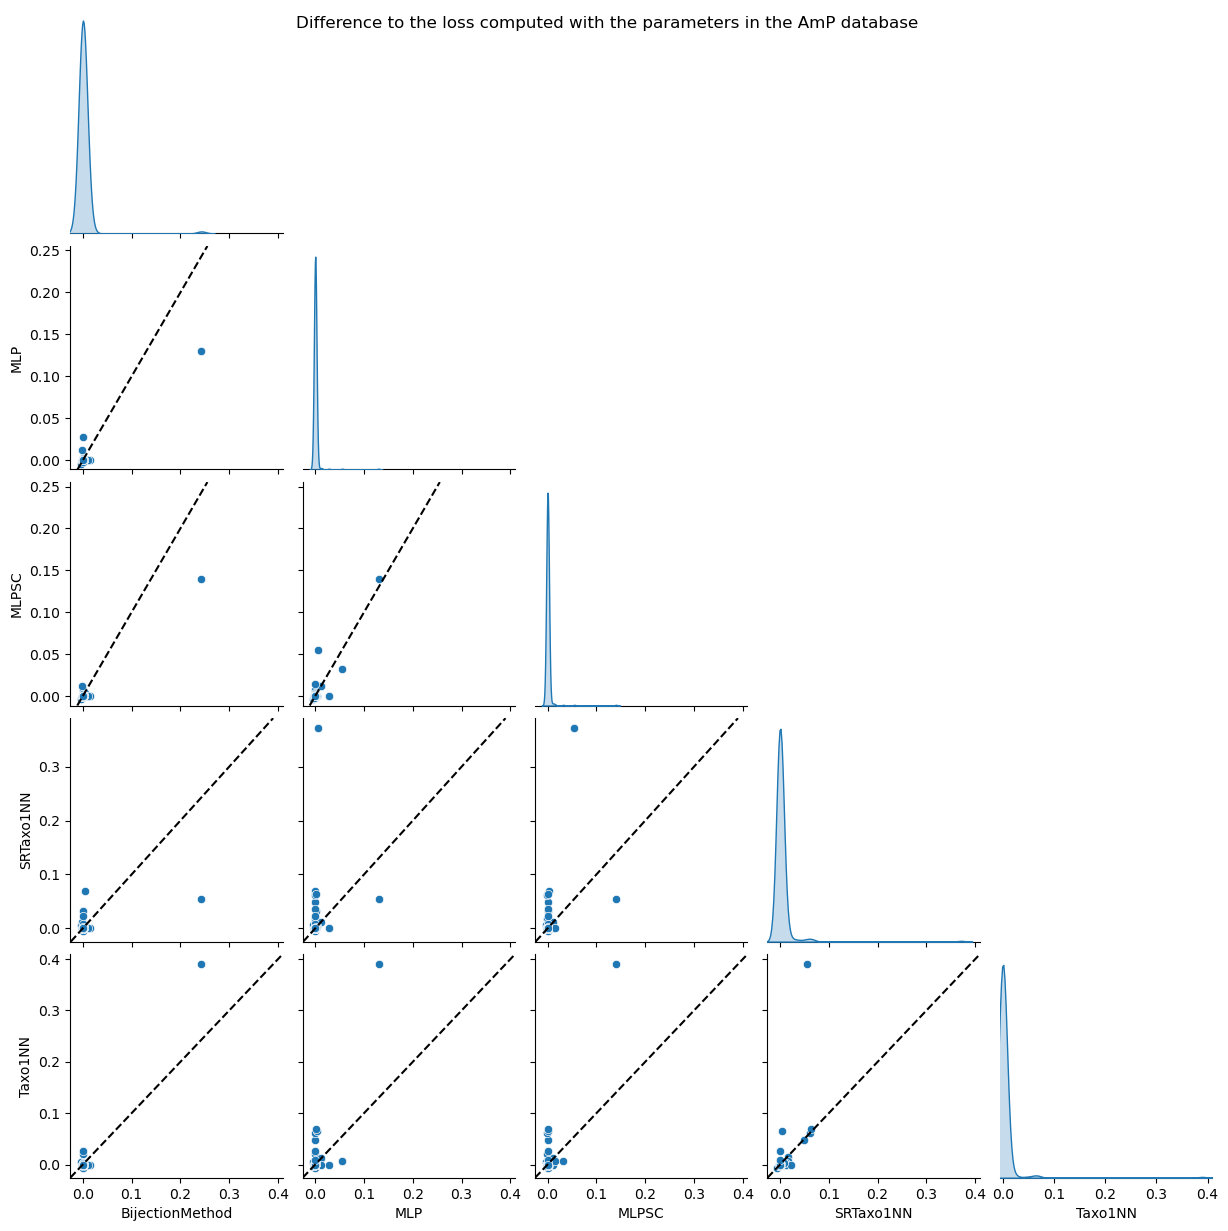

In [34]:
g = sns.pairplot(data=loss_diff_compare_df, corner=True, diag_kind='kde')
n_methods = len(loss_diff_compare_df.columns)
#fig, axes = plt.subplots(n_methods-1, n_methods-1, figsize=(16, 16), tight_layout=True)
g.figure.suptitle('Difference to the loss computed with the parameters in the AmP database')

for i in range(n_methods):
    y_col = loss_diff_compare_df.columns[i]
    for j in range(n_methods):
        
        ax = g.axes[i, j]
        x_col = loss_diff_compare_df.columns[j]
        if ax is not None:
            

            if i==j:
                min_v = (1-margin_factor)*min(loss_diff_compare_df[x_col].min(), loss_diff_compare_df[y_col].min())
                max_v = (1+margin_factor)*max(loss_diff_compare_df[x_col].max(), loss_diff_compare_df[y_col].max())
                ax.set_xlim([min_v, max_v])
            else:
                adjust_axes_to_square(ax)

## Gap to loss function

### Box plot

Text(0, 0.5, '')

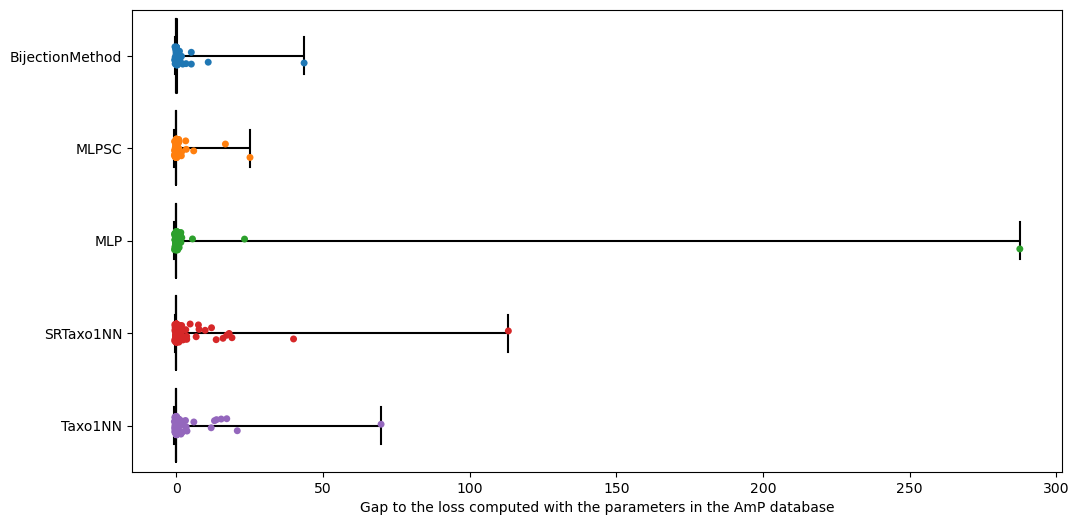

In [35]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
#ax.set_xscale('symlog')
sns.stripplot(ax=ax, data=loss_diff_df.reset_index(), x='loss_gap', y='method', hue='method')
sns.boxplot(ax=ax, data=loss_diff_df.reset_index(), x='loss_gap', y='method', color='black', fill=False, whis=1000000)
ax.set_xlabel('Gap to the loss computed with the parameters in the AmP database')
ax.set_ylabel('')

### Scatterplot

In [36]:
loss_gap_compare_df = loss_diff_df.pivot(columns='method', values='loss_gap')
loss_gap_compare_df

method,BijectionMethod,MLP,MLPSC,SRTaxo1NN,Taxo1NN
Row,,,,,
Ablennes_hians,1.732109,0.205011,-0.332532,0.397065,3.232983
Acanthiza_chrysorrhoa,NaN,-0.003792,0.007247,0.007738,-0.008309
Acanthogobius_flavimanus,0.000003,0.000343,0.000288,0.000169,0.000061
Acanthopagrus_arabicus,0.040286,-0.013853,0.000226,0.036023,-0.003038
Accipiter_fasciatus,NaN,0.000245,NaN,NaN,NaN
...,...,...,...,...,...
Varanus_bengalensis,NaN,0.0,0.0,0.0,0.0
Vermivora_cyanoptera,NaN,-0.002906,0.006271,-0.009057,0.006995
Wallabia_bicolor,NaN,0.0,0.0,0.0,1.839752


In [37]:
def scatterplot_loss_gap(method1, method2):
    ax = sns.scatterplot(data=loss_gap_compare_df, x=method1, y=method2)
    adjust_axes_to_square(ax)
    ax.grid(True)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_title('Gap to the loss computed with the parameters in the AmP database')


method1_selector = widgets.Dropdown(options=loss_diff_compare_df.columns, value='BijectionMethod', description='Method 1:')
method2_selector = widgets.Dropdown(options=loss_diff_compare_df.columns, value='MLP', description='Method 2:')
widgets.interactive(scatterplot_loss_gap, method1=method1_selector, method2=method2_selector)


interactive(children=(Dropdown(description='Method 1:', options=('BijectionMethod', 'MLP', 'MLPSC', 'SRTaxo1NN…

### Pairplot

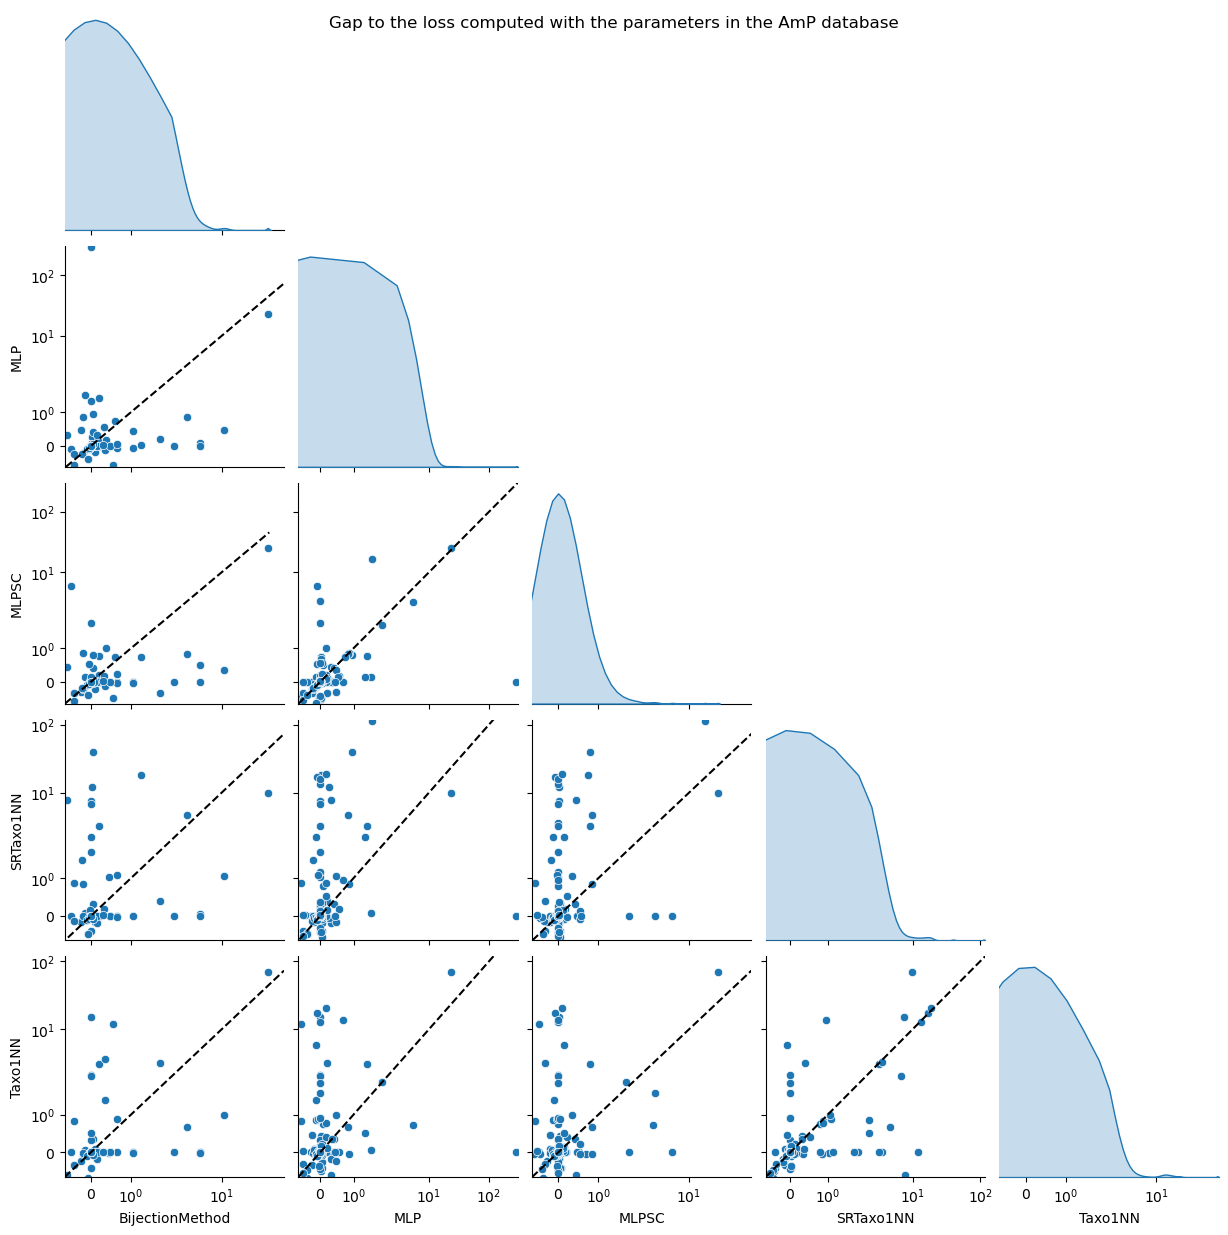

In [38]:
g = sns.pairplot(data=loss_gap_compare_df, corner=True, diag_kind='kde')
margin_factor = 0.05
n_methods = len(loss_gap_compare_df.columns)
#fig, axes = plt.subplots(n_methods-1, n_methods-1, figsize=(16, 16), tight_layout=True)
g.figure.suptitle('Gap to the loss computed with the parameters in the AmP database')

for i in range(n_methods):
    y_col = loss_gap_compare_df.columns[i]
    for j in range(n_methods):
        
        ax = g.axes[i, j]
        x_col = loss_gap_compare_df.columns[j]
        #print(i, y_col, j, x_col)
        #sns.scatterplot(data=loss_gap_compare_df, x=x_col, y=y_col, ax=ax)
        if ax is not None:
            min_v = (1-margin_factor)*min(loss_gap_compare_df[x_col].min(), loss_gap_compare_df[y_col].min())
            max_v = (1+margin_factor)*max(loss_gap_compare_df[x_col].max(), loss_gap_compare_df[y_col].max())
            #ax.set_xlabel(ax.get_xlabel()[9:])
            #ax.set_ylabel(ax.get_ylabel()[9:])
            ax.set_xscale('symlog')
            ax.set_xlim([min_v, max_v])

            if i==j:
                continue
            
            ax.plot([min_v, max_v], [min_v, max_v], 'k--')
            ax.set_ylim([min_v, max_v])

            ax.set_yscale('symlog')


            


# LaTeX Tables

In [39]:
def add_bold_latex_code(s):
    """
    Adds LaTeX bold formatting to the given string.
    """
    return f'\\textbf{{{s}}}'

## Comparison table

In [143]:
fail_stats_col_to_text = {
    'n_success': 'Successful runs',
    'n_failed': 'Method failed',
    'n_infeasible': 'Infeasible solutions',
    'n_fail_custom_filters': 'Did not pass custom filters',
    'n_errors': 'Execution errors',
    'n_timeouts': 'Time limit exceeded',
}

success_stats_col_to_text = {
    'n_minimum': 'Reached minimum', 
    'n_improved': 'Improved on minimum',
    'n_worsened': 'Found worse solution',
}
mean_perf_col_to_text = {
    'norm_init_loss_diff': 'Norm. initial loss diff.',
    'norm_loss_diff': 'Norm. final loss diff.',
    'execution_time': 'Execution time [s]',
    'n_iter': 'Number of iterations',
}
n_digits_of_metric = {
    'norm_init_loss_diff': 4,
    'norm_loss_diff': 4,
    'execution_time': 1,
    'n_iter': 0,
}

metric_best_function = {
    'n_success': None,
    'n_failed': None,
    'n_infeasible': None,
    'n_fail_custom_filters': None,
    'n_errors': None,
    'n_timeouts': None,

    'n_minimum': None,
    'n_improved': None,
    'n_worsened': None,

    'norm_init_loss_diff': min,
    'norm_loss_diff': min,
    'execution_time': min,
    'n_iter': min,
}

In [144]:

# Print header
print(r'\toprule')
line = r'\textbf{Metric}'
for mt in method_list:
    
    line += f' & {add_bold_latex_code(method_labels[mt])}'
line += ' \\\\'
print(line)
print(r'\midrule')

for col, text in fail_stats_col_to_text.items():
    line = f'{text}'
    func = metric_best_function[col]
    for mt in method_list:
        value = int(stats_df.at[mt, col])
        if func is not None and value == func(stats_df[col]):
            line += f' & {add_bold_latex_code(value)}'
        else:
            line += f' & {value}'
    line += ' \\\\'
    print(line)
print(r'\midrule')

for col, text in success_stats_col_to_text.items():
    line = f'{text}'
    func = metric_best_function[col]
    for mt in method_list:
        value = int(stats_df.at[mt, col])
        if func is not None and value == func(stats_df[col]):
            line += f' & {add_bold_latex_code(value)}'
        else:
            line += f' & {value}'
    line += ' \\\\'
    print(line)
print(r'\midrule')

for col, text in mean_perf_col_to_text.items():
    line = f'{text}'
    n_d = n_digits_of_metric[col]
    for mt in method_list:
        mean = mean_performance_df.at[mt, f'mean_{col}']
        std = mean_performance_df.at[mt, f'std_{col}']
        value = f'{mean:.{n_d}f} $\pm$ {std:.{n_d}f}'
        if mean == metric_best_function[col](mean_performance_df[f'mean_{col}']):
            line += f' & {add_bold_latex_code(value)}'
        else:
            line += f' & {value}'        
    line += ' \\\\'
    print(line)
print(r'\bottomrule')

\toprule
\textbf{Metric} & \textbf{Bijection} & \textbf{HC-NN} & \textbf{SC-NN} & \textbf{Taxo1NN} & \textbf{SR-Taxo1NN} \\
\midrule
Successful runs & 112 & 307 & 316 & 272 & 283 \\
Method failed & 200 & 0 & 0 & 0 & 0 \\
Infeasible solutions & 11 & 0 & 1 & 0 & 0 \\
Did not pass custom filters & 1 & 7 & 4 & 8 & 10 \\
Execution errors & 10 & 20 & 18 & 49 & 41 \\
Time limit exceeded & 19 & 19 & 14 & 24 & 19 \\
\midrule
Reached minimum & 47 & 99 & 106 & 79 & 90 \\
Improved on minimum & 19 & 105 & 99 & 95 & 90 \\
Found worse solution & 46 & 103 & 111 & 98 & 103 \\
\midrule
Norm. initial loss diff. & 0.0708 $\pm$ 0.1674 & 0.0615 $\pm$ 0.0782 & \textbf{0.0551 $\pm$ 0.0507} & 0.1331 $\pm$ 0.4210 & 0.0891 $\pm$ 0.0923 \\
Norm. final loss diff. & 0.0028 $\pm$ 0.0230 & \textbf{0.0008 $\pm$ 0.0083} & 0.0009 $\pm$ 0.0087 & 0.0028 $\pm$ 0.0248 & 0.0031 $\pm$ 0.0236 \\
Execution time [s] & 858.8 $\pm$ 1508.4 & 832.4 $\pm$ 1091.2 & \textbf{464.0 $\pm$ 883.9} & 858.7 $\pm$ 1190.4 & 921.0 $\pm$ 1152.1 \